In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
import cv2
import os
import sklearn

In [2]:
import pathlib 
cancer_dir = pathlib.Path("data/unhealthy")
normal_dir = pathlib.Path("data/healthy")

In [3]:
dirlist=[cancer_dir,normal_dir ]
classes=['Yes', 'No']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  10048    labels:  10048


In [4]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(10048,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,data\unhealthy\WBC-Malignant-Early-001.jpg,Yes
1,data\unhealthy\WBC-Malignant-Early-002.jpg,Yes
2,data\unhealthy\WBC-Malignant-Early-003.jpg,Yes
3,data\unhealthy\WBC-Malignant-Early-004.jpg,Yes
4,data\unhealthy\WBC-Malignant-Early-005.jpg,Yes


In [5]:
print(df['labels'].value_counts())

labels
Yes    5504
No     4544
Name: count, dtype: int64


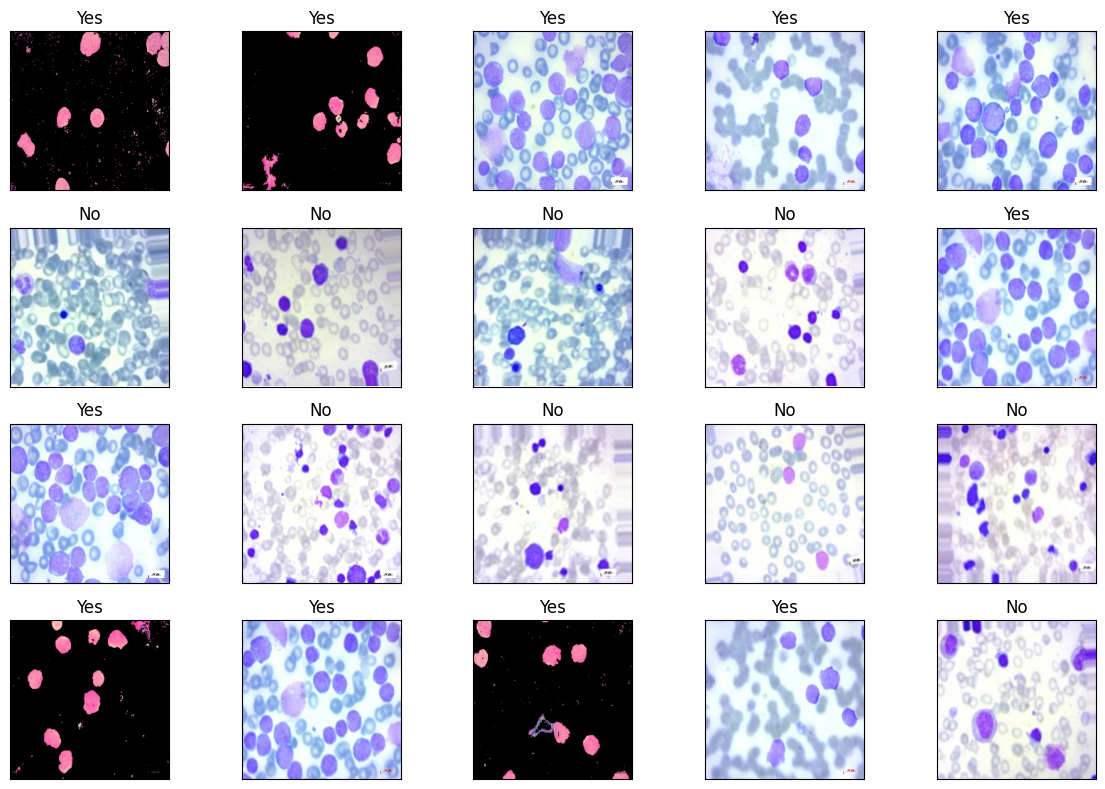

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(12, 8))

for i in range(20):
    random_idx = np.random.randint(0, len(df))  # Use random index correctly
    plt.subplot(4, 5, i + 1)

    # Load image using PIL instead of OpenCV
    img = Image.open(df.loc[random_idx, "filepaths"])
    
    # Display image
    plt.imshow(img)
    plt.title(df.loc[random_idx, "labels"], size=12, color="black")  
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()


In [7]:
labels = ['CANCER', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [8]:
import glob
images_dict = {
    'cancer': list(cancer_dir.glob('*')) ,   
    'normal': list(normal_dir.glob('*'))  
}

labels_dict = {
    'cancer': "cancer",
    'normal': "normal",
    
}

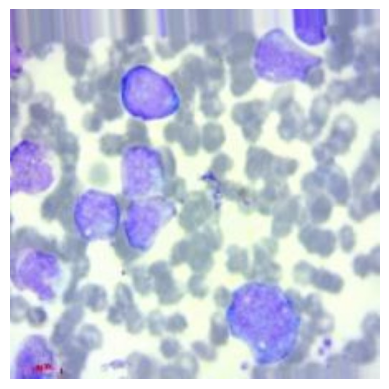

In [9]:
import PIL.Image as Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load image using PIL instead of OpenCV
img = Image.open(str(images_dict['normal'][0]))

# Display the image
plt.imshow(img)
plt.axis("off")  # Hides axes for better visualization
plt.show()


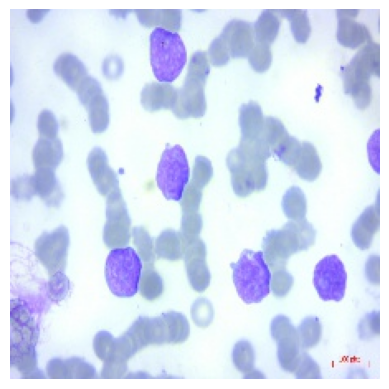

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image using PIL instead of OpenCV
img2 = Image.open(str(images_dict['cancer'][0]))

# Display the image
plt.imshow(img2)
plt.axis("off")  # Hides axes for a clean view
plt.show()


In [11]:
X, y = [], []
for name,images in images_dict.items():
    for image in images:
        img=str(image)

        X.append(img)
        y.append(labels_dict[name])

In [12]:
Fseries = pd.Series(X, name="filepaths",dtype=str)
Lseries = pd.Series(y, name="labels",dtype=str)
cancer_data = pd.concat([Fseries,Lseries], axis=1)
cancer_df = pd.DataFrame(cancer_data)

print(cancer_df.head())
print("---------------------")
print(cancer_df["labels"].value_counts())

                                    filepaths  labels
0  data\unhealthy\WBC-Malignant-Early-001.jpg  cancer
1  data\unhealthy\WBC-Malignant-Early-002.jpg  cancer
2  data\unhealthy\WBC-Malignant-Early-003.jpg  cancer
3  data\unhealthy\WBC-Malignant-Early-004.jpg  cancer
4  data\unhealthy\WBC-Malignant-Early-005.jpg  cancer
---------------------
labels
cancer    5504
normal    4544
Name: count, dtype: int64


In [13]:
cancer_df.shape

(10048, 2)

In [14]:
from sklearn.model_selection import train_test_split
train_images, test_images = train_test_split(cancer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(cancer_df, test_size=0.2, random_state=42)

In [15]:
print(train_images.shape)
print(test_images.shape)
print(train_set.shape)
print(val_set.shape)

(7033, 2)
(3015, 2)
(8038, 2)
(2010, 2)


In [16]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_images,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=32,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 7033 validated image filenames belonging to 2 classes.
Found 3015 validated image filenames belonging to 2 classes.
Found 2010 validated image filenames belonging to 2 classes.


In [17]:
classes=list(train.class_indices.keys())
print (classes)

['cancer', 'normal']


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(244,244,3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(2, activation='softmax') 
])


d:\Projects\Bilstrim and other 4 models\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 242, 242, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 121, 121, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 119, 119, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 222784)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    28,516,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,536,130 (108.86 MB)

 Trainable params: 28,536,130 (108.86 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
History = model.fit(train, validation_data= val, epochs=10,verbose=1)

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 113s 515ms/step - accuracy: 0.8517 - loss: 0.4250 - val_accuracy: 0.9065 - val_loss: 0.2513
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 113s 511ms/step - accuracy: 0.9084 - loss: 0.2292 - val_accuracy: 0.9139 - val_loss: 0.2178
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 113s 516ms/step - accuracy: 0.9316 - loss: 0.1652 - val_accuracy: 0.9398 - val_loss: 0.1505
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 516ms/step - accuracy: 0.9542 - loss: 0.1115 - val_accuracy: 0.9423 - val_loss: 0.1531
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 517ms/step - accuracy: 0.9746 - loss: 0.0743 - val_accuracy: 0.9289 - val_loss: 0.2932
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 113s 515ms/step - accuracy: 0.9795 - loss: 0.0542 - val_accuracy: 0.9333 - val_loss: 0.2434
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 516ms/step - accuracy: 0.9816 - loss: 0.0554 - val_accuracy: 0.9388 - val_loss: 0.2169
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 516ms/step - accuracy: 0.9836 -

In [27]:
model.evaluate(test)

95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.9319 - loss: 0.2282


[0.23431561887264252, 0.9306799173355103]

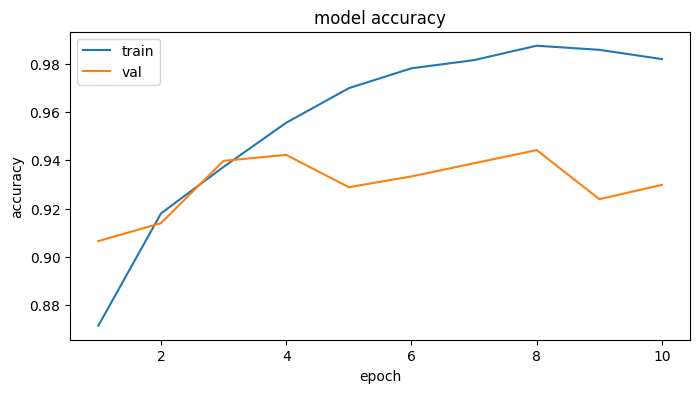

In [28]:
plt.figure(figsize=(8,4))
epochs=range(1,len(History.history['val_accuracy'])+1)

plt.plot(epochs,History.history["accuracy"])
plt.plot(epochs,History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

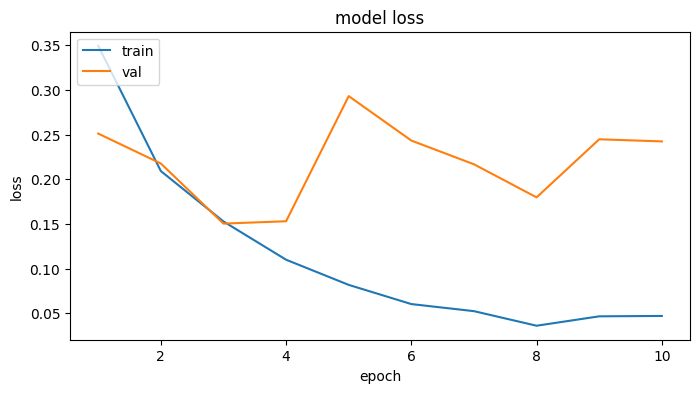

In [29]:
plt.figure(figsize=(8,4))
epochs=range(1,len(History.history['val_loss'])+1)

plt.plot(epochs,History.history["loss"])
plt.plot(epochs,History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
predict_classes = np.argmax(model.predict(test), axis= -1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step


In [31]:
from sklearn.metrics import confusion_matrix
y_list = test_images['labels'].to_list()
y_test = []
for i in range(len(y_list)):
    if y_list[i] == 'normal':
        y_test.append(0)
    else:
        y_test.append(1)
y_test = np.array(y_test)
cm = confusion_matrix(y_test, predict_classes)
cm

array([[ 108, 1220],
       [1586,  101]])

In [32]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])


<Axes: >

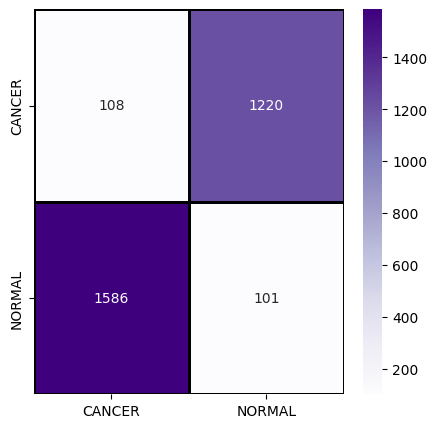

In [33]:
from keras.layers import Dense, Conv2D
plt.figure(figsize = (5,5))
sns.heatmap(cm ,cmap= "Purples", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [34]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def predict_image(image_path, model, labels):
    """
    Predict if an image is cancer or normal.

    Parameters:
        image_path (str): Path to the input image.
        model (keras.Model): Trained CNN model.
        labels (list): List of class labels.

    Returns:
        str: Predicted class label.
    """
    img = load_img(image_path, target_size=(244, 244))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)

    return labels[predicted_class]

image_path = "data/healthy/WBC-Benign-009.jpg"

predicted_label = predict_image(image_path, model, labels)
print(f"The predicted class for the input image is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
The predicted class for the input image is: NORMAL


95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step


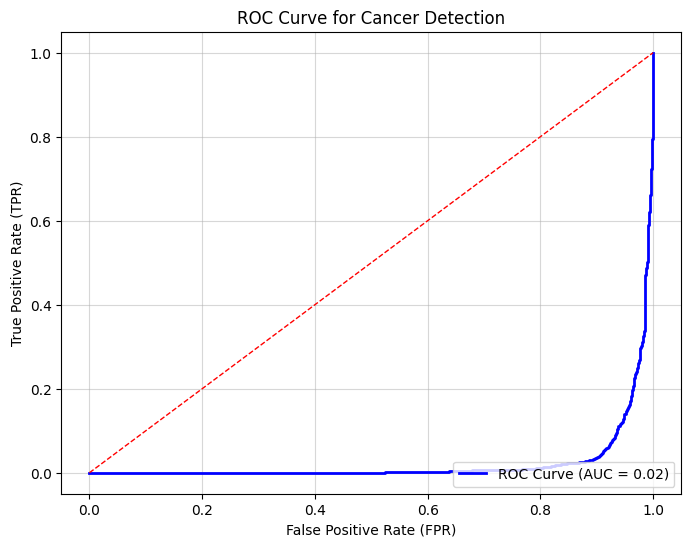

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_prob = model.predict(test)  
y_pred = np.argmax(y_prob, axis=1)  
y_true = y_test  

fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1]) 
roc_auc = auc(fpr, tpr) 

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=1) 
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Cancer Detection')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()